<a href="https://colab.research.google.com/github/filmer2002/RASH_INSPECTOR/blob/master/bodyskin_VGG16_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **VGG16**
Let's implement !!!

In [0]:
import tensorflow as tf
import keras
from keras import backend as K
from keras import models
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from vis.utils import utils
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import PIL
import cv2

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!git clone https://github.com/filmer2002/RASH_INSPECTOR_data

Cloning into 'RASH_INSPECTOR_data'...
remote: Enumerating objects: 4594, done.
remote: Counting objects: 100% (4594/4594), done.
remote: Compressing objects: 100% (4594/4594), done.
remote: Total 4594 (delta 0), reused 4594 (delta 0), pack-reused 0
Receiving objects: 100% (4594/4594), 43.82 MiB | 23.55 MiB/s, done.


In [0]:
train_path = '/content/RASH_INSPECTOR_data/bodyskin/train'
val_path = '/content/RASH_INSPECTOR_data/bodyskin/val'
test_path = '/content/RASH_INSPECTOR_data/bodyskin/test'

In [0]:
img_size = 224
epochs = 30
batch_size = 32

In [0]:
train_norm = ImageDataGenerator(rescale=1. / 255) 
val_norm = ImageDataGenerator(rescale=1. / 255) 
test_norm = ImageDataGenerator(rescale=1. / 255) 

In [0]:
train_generator = train_norm.flow_from_directory( 
    train_path, 
    target_size=(img_size, img_size), 
    batch_size=batch_size)

val_generator = val_norm.flow_from_directory( 
    val_path, 
    target_size=(img_size, img_size), 
    batch_size=batch_size)

test_generator = test_norm.flow_from_directory( 
    test_path, 
    target_size=(img_size, img_size), 
    batch_size=batch_size,
    shuffle=False)

Found 1520 images belonging to 2 classes.
Found 190 images belonging to 2 classes.
Found 190 images belonging to 2 classes.


In [0]:
num_train_files = len(train_generator.filenames)
num_train_classes = len(train_generator.class_indices)
print('num_train_files', num_train_files, '&', 'num_train_classes', num_train_classes )

num_val_files = len(val_generator.filenames)
num_val_classes = len(val_generator.class_indices)
print('num_val_files', num_val_files, '&', 'num_val_classes', num_val_classes )

num_test_files = len(test_generator.filenames)
num_test_classes = len(test_generator.class_indices)
print('num_test_files', num_test_files, '&', 'num_test_classes', num_test_classes )

num_train_files 1520 & num_train_classes 2
num_val_files 190 & num_val_classes 2
num_test_files 190 & num_test_classes 2


In [0]:
train_steps = np.ceil(num_train_files/batch_size)
val_steps = np.ceil(num_val_files/batch_size)

In [0]:
model = VGG16(weights='imagenet')





553467904/553467096 [==============================] - 16s 0us/step








In [0]:
x = model.layers[-2].output
predictions = Dense(num_train_classes, activation='softmax')(x)
model = Model(inputs=model.input, outputs=predictions)

In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
model.compile(Adam(lr=0.01), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [0]:
model_path = '/content/drive/My Drive/โครงงานผื่น/RASH_INSPECTOR/ORGAN/bodyskin/VGG16/bodyskin_vgg16_model.h5'

In [0]:
checkpoint = ModelCheckpoint(model_path, monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max')

In [0]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

In [0]:
log_dir = '/content/drive/My Drive/โครงงานผื่น/RASH_INSPECTOR/ORGAN/bodyskin/VGG16/tf-log/'
tb_cb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

In [0]:
cb_list = [checkpoint, early_stop, reduce_lr, tb_cb]

In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps,
                              validation_data=val_generator,
                              validation_steps=val_steps,
                              epochs=epochs,
                              verbose=1,
                              callbacks=cb_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Epoch 1/30
48/48 [==============================] - 67s 1s/step - loss: 7.9478 - acc: 0.4987 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to /content/drive/My Drive/โครงงานผื่น/RASH_INSPECTOR/ORGAN/bodyskin/VGG16/bodyskin_vgg16_model.h5

Epoch 2/30
48/48 [==============================] - 48s 1s/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00002: val_acc did not improve from 0.50000
Epoch 3/30
48/48 [==============================] - 48s 998ms/step - loss: 8.0282 - acc: 0.5019 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00003: val_acc improved from 0.50000 to 0.50000, saving model to /content/drive/My Drive/โครงงานผื่น/RASH_INSPECTOR/ORGAN/bodyskin/VGG16/bodyskin_vgg16_model.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
Epoch 4/30
48/48 [=========================

In [0]:
model.save_weights('/content/drive/My Drive/โครงงานผื่น/RASH_INSPECTOR/ORGAN/bodyskin/VGG16/bodyskin_vgg16_weights.h5')

In [0]:
model.load_weights(model_path)

val_loss, val_acc = \
model.evaluate_generator(test_generator, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 8.059047759206676
val_acc: 0.5


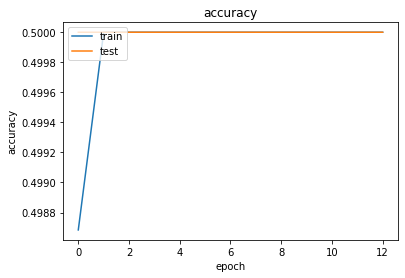

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.title('accuracy')
plt.show()

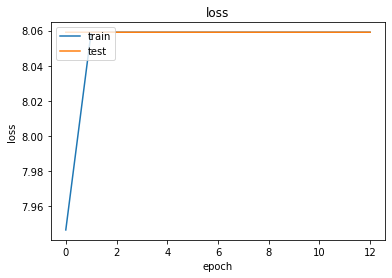

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.title('loss')
plt.show()

In [0]:
Y_pred = model.predict_generator(test_generator, num_test_files//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
classes_names = ['AD', 'Other']
print(classification_report(test_generator.classes, y_pred, target_names=classes_names))

Confusion Matrix
[[95  0]
 [95  0]]
Classification Report
              precision    recall  f1-score   support

          AD       0.50      1.00      0.67        95
       Other       0.00      0.00      0.00        95

    accuracy                           0.50       190
   macro avg       0.25      0.50      0.33       190
weighted avg       0.25      0.50      0.33       190



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
predictions = model.predict_generator(test_generator, steps=val_steps, verbose=1)

6/6 [==============================] - 2s 297ms/step


In [0]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
cm_plot_labels = ['AD', 'Other']

Confusion matrix, without normalization
[[95  0]
 [95  0]]


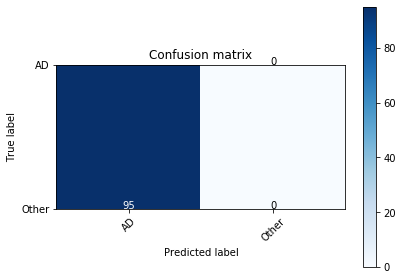

In [0]:
cm = confusion_matrix(test_generator.classes, predictions.argmax(axis=1))
plot_confusion_matrix(cm, cm_plot_labels)